## Homework2

### Tasks (Classifier evaluation)

##### 1. The code currently does not perform any train/test splits. Split the data into training, validation, and test sets, via 1/3, 1/3, 1/3 splits. Use random splits of the data (i.e., each should be a random, non- overlapping sample of the data; this can be obtained by first shuffling the data). After training on the training set, report the accuracy of the classifier on the validation and test sets (1 mark).

In [1]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
from math import exp
from math import log
from sklearn.utils import shuffle

In [2]:
def parseDataFromFile(fname):
  for l in open(fname):
    yield eval(l)

In [3]:
data = list(parseDataFromFile("beer_50000.json"))

In [4]:
def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

In [5]:
data_shuffle = shuffle(data, random_state = 0)

In [6]:
X = [feature(d) for d in data_shuffle]
y = [d['beer/ABV'] >= 6.5 for d in data_shuffle]

In [7]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

In [8]:
X_train = X[:int(len(X)/3)]
X_valid = X[int(len(X)/3): int(2*len(X)/3)]
X_test = X[int(2*len(X)/3):]
y_train = y[:int(len(y)/3)]
y_valid = y[int(len(y)/3): int(2*len(y)/3)]
y_test = y[int(2*len(y)/3):]

In [9]:
# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta) 
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

In [10]:
def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

In [11]:
def performance(theta):
  scores = [inner(theta,x) for x in X_train]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y_train)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

In [12]:
def performance_valid(theta):
  scores = [inner(theta,x) for x in X_valid]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y_valid)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

In [13]:
def performance_test(theta):
  scores = [inner(theta,x) for x in X_test]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y_test)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

In [14]:
#accuracy of the classifier on valid set
lam = 1.0

theta = train(lam)
acc = performance_valid(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 1.0:	accuracy=0.7180656386872263


In [15]:
#accuracy of the classifier on test set
lam = 1.0

theta = train(lam)
acc = performance_test(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 1.0:	accuracy=0.7187856242875142


##### 2. Report the number of Positives, Negatives, True Positives, True Negatives, False Positives, and False Negatives using the test set of the classifier you trained above (1 mark).

In [16]:
scores = [inner(theta,x) for x in X_test]
predictions = [s > 0 for s in scores]
correct = [(a==b) for (a,b) in zip(predictions,y_test)]
acc = sum(correct) * 1.0 / len(correct)

In [17]:
#Positives
positive = sum(predictions)
positive

12485

In [18]:
#Negatives
negative = len(predictions) - sum(predictions)
negative

4182

In [19]:
#True Positive
test_positive = [(a==b==1) for (a,b) in zip(predictions,y_test)]
true_positive = sum(test_positive)
true_positive

9089

In [20]:
#False Positive
false_positive = positive - true_positive
false_positive

3396

In [21]:
#True Negative
test_negative = [(a==b==0) for (a,b) in zip(predictions,y_test)]
true_negative = sum(test_negative)
true_negative

2891

In [22]:
#False Negative
false_negative = negative - true_negative
false_negative

1291

##### 3. (Hard) Describe how you would modify the code stub provided if you wanted to assign greater importance to False Positives compared to False Negatives. Suggest specific modifications that would make to the code if you wanted to assign 10 times as much importance to False Positives as compared to False Negatives.

##### According to the cost function = c1 * y * log(h(theta)) + c2 * (1-y) * log(1-h(theta)), the first part of the equation calculate false positives and the latter part calcualte false negatives. In order to assign greater importance to false positives compared to false negatives, we only need to adjust the coeffecients of c1/c2. If we want to assign 10 times as much importance to false positives as compared to false negatives, we need to time log(10) in the latter part of the equation. So in the def function code above, we should change NEGATIVE Log-likelihood - loglikelihood -= logit * log(10) and change NEGATIVE Derivative of log-likelihood - dl[k] -= X[i][k] * log(10)).

##### 4. Implement a training/validation/test pipeline so that you can select the best model based on its performance on the validation set. Try models with lamda {0, 0.01, 0.1, 1, 100}. Report the performance on the training/validation/test sets for the best value of lamda (1 mark).

In [23]:
# When lam = 0, accuracy of the classifier on valid set
lam = 0

theta = train(lam)
acc = performance_valid(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 0:	accuracy=0.7178856422871542


In [24]:
# When lam = 0.01, accuracy of the classifier on valid set
lam = 0.01

theta = train(lam)
acc = performance_valid(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 0.01:	accuracy=0.7178256434871303


In [25]:
# When lam = 0.1, accuracy of the classifier on valid set
lam = 0.1

theta = train(lam)
acc = performance_valid(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 0.1:	accuracy=0.7181256374872502


In [26]:
# When lam = 1, accuracy of the classifier on valid set
lam = 1

theta = train(lam)
acc = performance_valid(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 1:	accuracy=0.7180656386872263


In [27]:
# When lam = 100, accuracy of the classifier on valid set
lam = 100

theta = train(lam)
acc = performance_valid(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 100:	accuracy=0.6723465530689386


##### When try models with lamda {0, 0.01, 0.1, 1, 100}, we find that lamda = 0.1 is the best model becasue it has highest accuracy on validation set. 

In [28]:
# When lam = 0.1, accuracy of the classifier on train set
lam = 0.1

theta = train(lam)
acc = performance(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 0.1:	accuracy=0.71906876275051


In [29]:
# When lam = 0.1, accuracy of the classifier on test set
lam = 0.1

theta = train(lam)
acc = performance_test(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 0.1:	accuracy=0.7192056158876823


##### Setting the lamda = 0.01, the performance on the training set is 0.71906876275051, on the validation set is 0.7181256374872502 and on the test set is 0.7192056158876823.

### Tasks (Community Detection)

##### 5. How many connected components are in the graph, and how many nodes are in the largest connected component (1 mark)?

In [30]:
!pip3 install --user networkx

  Using cached https://files.pythonhosted.org/packages/bc/bb/a24838832ba35baf52f32ab1a49b906b5f82fb7c76b2f6a7e35e140bac30/decorator-4.3.0-py2.py3-none-any.whl


In [31]:
### Network visualization ###
import networkx as nx
import matplotlib.pyplot as plt

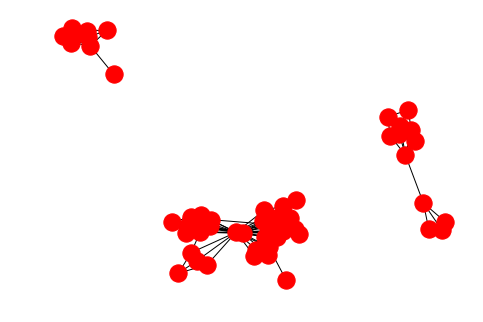

<Figure size 432x288 with 0 Axes>

In [32]:
edges = set()
nodes = set()
for edge in open('egonet.txt'):
  x,y = edge.split()
  x,y = int(x),int(y)
  edges.add((x,y))
  edges.add((y,x))
  nodes.add(x)
  nodes.add(y)

G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

In [33]:
nx.number_connected_components(G)

3

In [34]:
len(max(nx.connected_components(G), key=len))

40

##### Next we'll implement a `greedy' version of normalized cuts, using just the largest connected component found above. First, split it into two equal halves, just by taking the 50% of nodes with the lowest and 50% with the highest IDs.

##### 6. What is the normalized-cut cost of the 50/50 split you found above (1 mark)?

In [35]:
largest = max(nx.connected_components(G), key=len)

In [36]:
low = sorted(largest)[:int(len(largest)/2)]
high = sorted(largest)[int(len(largest)/2):]

In [37]:
edges_large = set()
nodes_large = set()

for i in low:
    for j in low:
        for a in high:
            for b in high:
                if (i,j) in edges:
                    edges_large.add((i,j))
                    edges_large.add((j,i))
                    nodes_large.add(i)
                    nodes_large.add(j)
                if(i,a) in edges:
                    edges_large.add((i,a))
                    edges_large.add((a,i))
                    nodes_large.add(i)
                    nodes_large.add(a)
                if(i,b) in edges:
                    edges_large.add((i,b))
                    edges_large.add((b,i))
                    nodes_large.add(i)
                    nodes_large.add(b)
                if(j,a) in edges:
                    edges_large.add((a,j))
                    edges_large.add((j,a))
                    nodes_large.add(a)
                    nodes_large.add(j)
                if(j,b) in edges:
                    edges_large.add((b,j))
                    edges_large.add((j,b))
                    nodes_large.add(b)
                    nodes_large.add(j)
                if(a,b) in edges:
                    edges_large.add((a,b))
                    edges_large.add((b,a))
                    nodes_large.add(a)
                    nodes_large.add(b)

In [38]:
G_1 = nx.Graph()
for e in edges_large:
  G_1.add_edge(e[0],e[1])

In [39]:
m = nx.normalized_cut_size(G_1, high, low, weight = 0.5)/2
m

0.4224058769513316

##### Now we'll implement our greedy algorithm as follows: during each step, we'll move one node from one cluster to the other, choosing whichever move minimizes the resulting normalized cut cost (in case of a tie, pick the node with the lower ID). Repeat this until the cost can't be reduced any further.

##### 7. What are the elements of the split, and what is its normalized cut cost (1 mark)?

In [40]:
u = []
def abc(low, high):
    p = []
    q = 0
    while q < len(low):
        high.append(low[0])
        del low[0] 
        n = nx.normalized_cut_size(G_1, high, low)/2
        p.append(n)
        q+=1
        low.append(high[-1])
        del high[-1]
    r = 0
    while r < len(high):
        low.append(high[0])
        del high[0] 
        n = nx.normalized_cut_size(G_1, high, low)/2
        p.append(n)
        r+=1
        high.append(low[-1])
        del low[-1]
    t = min(p)
    x = p.index(t)
    u.append(t)
    if x < len(low):
        high.append(low[x])
        del low[x]
    if x >= len(low):
        low.append(high[x-len(low)])
        del high[x+1-len(low)]
    return(low,high)

In [41]:
abc(low,high)
for e in range(20):
    if len(u) <= 1:
        abc(low,high)
    else:
        if u[e] < u[e-1]:
            abc(low,high)
        else:
            print(u[e-1])
            print(abc(low,high))
            break  

0.09817045961624274
([697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 800, 803, 805, 810, 811, 819, 828, 823, 830, 840, 880, 890, 869, 856, 798], [825, 861, 863, 864, 876, 878, 882, 884, 886, 888, 889, 893, 729, 804])


##### 8. Re-implement your greedy algorithm above so that it maximizes the modularity, rather than the normalized cut cost. Report modularity values for the 50/50 split you find (1 mark).

In [42]:
u = []
def fgh(low, high):
    p = []
    q = 0
    while q < len(low):
        high.append(low[0])
        del low[0] 
        n = nx.algorithms.community.modularity(G_1,[low,high])
        p.append(n)
        q+=1
        low.append(high[-1])
        del high[-1]
    r = 0
    while r < len(high):
        low.append(high[0])
        del high[0] 
        n = nx.algorithms.community.modularity(G_1,[low,high])
        p.append(n)
        r+=1
        high.append(low[-1])
        del low[-1]
    t = max(p)
    x = p.index(t)
    u.append(t)
    if x < len(low):
        high.append(low[x])
        del low[x]
    if x >= len(low):
        low.append(high[x-len(low)])
        del high[x+1-len(low)]
    return(low, high)

In [43]:
low = sorted(largest)[:int(len(largest)/2)]
high = sorted(largest)[int(len(largest)/2):]

In [44]:
fgh(low,high)
for e in range(20):
    if len(u) <= 1:
        fgh(low,high)
    else:
        if u[e] >= u[e-1]:
            fgh(low,high)
        else:
            print(u[e-1])
            break  

0.33801652892561973
